In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table
project_id = 'tutorial-258411'
%env GCLOUD_PROJECT=tutorial-258411

from google.cloud import bigquery
client = bigquery.Client(project=project_id)

Authenticated
env: GCLOUD_PROJECT=tutorial-258411


In [3]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import time
import os, json

!pip install fbprophet
from fbprophet import Prophet

!pip install pingouin
import pingouin as pg

stu_path = '/content/drive/My Drive/Colab Notebooks/data/studentLife'

In [0]:
def get_json_list(attr='Stress'):
    # get path by concatenation
    dir_attr = os.path.join(stu_path, 'EMA', 'response', attr)

    # get and sort the filename list
    json_list = [pos_json for pos_json in os.listdir(dir_attr) \
                    if pos_json.endswith('.json')]
    json_list.sort()

    return json_list


def get_csv_list(attr='conversation'):
    dir_attr = os.path.join(stu_path, 'sensing', attr)

    # get and sort the filename list
    csv_list = [pos_json for pos_json in os.listdir(dir_attr) \
                if pos_json.endswith('.csv')]
    csv_list.sort()
    return csv_list

### Load Stress Data
1. Get direction path and use a filter to get all the `.json` files in this directory.
2. Read `.json` files to Pandas dataframe according to the sorted filename list generated in step 1.
3. Kick out the files which do not contain even `resp_time` and `level` information. We find that `u13` should be rejected.
4. For each qualified (e.g. with `resp_time` and `level` columns) file, take these columns and add a new column called `student_id` taken from the filename.
5. Instead of manually deleting the useless rows at the beginning of the file, we remove such rows by `df.dropna()`.

In [5]:
stress_df = []
json_stress_list = get_json_list('Stress')

# for file_name in json_files:
for file_name in json_stress_list:
    # read json
    df = pd.read_json(
        os.path.join(stu_path, 'EMA/response/Stress', file_name),
        dtype={'level': int})

    # only accept .json files containing the two columns we require   
    if 'resp_time' in df.columns.to_list() \
        and 'level' in df.columns.to_list(): 
        # accept this file
        print(file_name, df.columns.to_list(), '=' * 5 + '>', 'accepted')

        # reformat column names
        df.columns = df.columns.str.replace(' ', '_')
        
        # reformat timestamp
        df['resp_time'] = pd.to_datetime(df['resp_time'], unit='s')
        df['date'] = df['resp_time'].dt.date
        df['time'] = df['resp_time'].dt.time

        # add student_id from filename
        student_id = file_name[7: 10]
        df.insert(0, 'student_id', student_id)

        # drop the rows with NaN in 'level' or 'resp_time'
        df.dropna(subset = ['resp_time', 'level'], inplace=True)
        
        # take only the columns we need
        df = df[['student_id', 'date', 'time', 'level']]
        stress_df.append(df)
    
    else: # reject this file
        print(file_name, df.columns.to_list(), '=' * 5 + '>', 'rejected')

# concatenate all the .json files into one big table
stress_table = pd.concat(stress_df)
print(stress_table.head().to_string(index=False))

Stress_u00.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u01.json ['level', 'location', 'resp_time', 'null'] =====> accepted
Stress_u02.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u03.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u04.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u05.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u07.json ['level', 'location', 'resp_time', 'null'] =====> accepted
Stress_u08.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u09.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u10.json ['level', 'location', 'resp_time', 'null'] =====> accepted
Stress_u12.json ['level', 'location', 'resp_time', 'null'] =====> accepted
Stress_u13.json ['null', 'resp_time'] =====> rejected
Stress_u14.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u15.json ['null', 'resp_time', 'level',

### Load Activity Data
1. Get direction path and use a filter to get all the `.json` files in this directory.
2. Read `.json` files to Pandas dataframe.
3. Kick out the files which do not contain 4 activity columns. We find that `u05`, `u09`, `u13` should be rejected.
4. For each qualified file, take required columns and add a new column called `student_id`, similarly done as above.
5. Remove rows with NaN by `df.dropna()`.

In [6]:
activity_df = [] # a list storing the df of each qualified .json file
json_activity_list = get_json_list('Activity')

for file_name in json_activity_list:
    # read json
    df = pd.read_json(
        os.path.join(stu_path, 'EMA/response/Activity', file_name)
    )

    # only accept .json files containing the columns we require   
    if len(df.columns.to_list()) > 5: 
        # reformat column names
        df.columns = df.columns.str.replace(' ', '_')
        
        # accept this file
        print(file_name, df.columns.to_list(), '=' * 5 + '>', 'accepted')
        
        # reformat timestamp "resp_time" into date
        df['resp_time'] = pd.to_datetime(df['resp_time'], unit='s')
        df['date'] = df['resp_time'].dt.date
        df['time'] = df['resp_time'].dt.time
        
        # take only the columns we need
        columns_required = ['date', 'time', 'relaxing', 'working', \
                            'other_relaxing', 'other_working', ]
        df = df[columns_required]

        # add student_id from filename
        student_id = file_name[9: 12]
        df.insert(0, 'student_id', student_id)

        # in each accepted file, drop the rows with NaN
        df.dropna(subset = columns_required, inplace=True)
        activity_df.append(df)
    
    else: # reject this file
        print(file_name, df.columns.to_list(), '=' * 5 + '>', 'rejected')

# concatenate all the .json files into one big table
activity_table = pd.concat(activity_df)
print(activity_table.head().to_string(index=False))

Activity_u00.json ['Social2', 'null', 'resp_time', 'other_relaxing', 'other_working', 'relaxing', 'working', 'location'] =====> accepted
Activity_u01.json ['Social2', 'null', 'resp_time', 'other_relaxing', 'other_working', 'relaxing', 'working', 'location'] =====> accepted
Activity_u02.json ['Social2', 'null', 'resp_time', 'other_relaxing', 'other_working', 'relaxing', 'working', 'location'] =====> accepted
Activity_u03.json ['Social2', 'null', 'resp_time', 'other_relaxing', 'other_working', 'relaxing', 'working', 'location'] =====> accepted
Activity_u04.json ['Social2', 'null', 'resp_time', 'other_relaxing', 'other_working', 'relaxing', 'working', 'location'] =====> accepted
Activity_u05.json ['Social2', 'null', 'resp_time'] =====> rejected
Activity_u07.json ['Social2', 'null', 'resp_time', 'other_relaxing', 'other_working', 'relaxing', 'working', 'location'] =====> accepted
Activity_u08.json ['Social2', 'null', 'resp_time', 'other_relaxing', 'other_working', 'relaxing', 'working', 'l

### Load Sensing Activity Data

In [7]:
sen_act_df = [] # a list storing the df of each qualified .json file
csv_sen_act_list = get_csv_list('activity')

for file_name in csv_sen_act_list:
    # read csv
    df = pd.read_csv(
        os.path.join(stu_path, 'sensing/activity', file_name))

    # only accept .json files containing the columns we require   
    if len(df.columns.to_list()) > 1: 
        # reformat column names
        df.columns = df.columns.str.replace(' ', '_')
        df.rename(columns={'_activity_inference': 'activity_level'}, 
                  inplace=True)
        
        # reformat timestamp into date
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df['date'] = df['timestamp'].dt.date
        df['time'] = df['timestamp'].dt.time
        
        # take only the columns we need
        columns_required = ['date', 'time', 'activity_level']
        df = df[columns_required]

        # in each accepted file, drop the rows with NaN
        df.dropna(subset = columns_required, inplace=True)

        # group by sum of date
        df = df.groupby(
            by = ['date'], 
            as_index=False).agg({'activity_level': 'sum'})

        # add student_id from filename
        student_id = file_name[9: 12]
        df.insert(0, 'student_id', student_id)     
        
        sen_act_df.append(df)
    
    else: # reject this file
        print(file_name, df.columns.to_list(), '=' * 5 + '>', 'rejected')

# concatenate all the .json files into one big table
sen_act_table = pd.concat(sen_act_df)
print(sen_act_table.head().to_string(index=False))

student_id        date  activity_level
       u00  2013-03-27            1955
       u00  2013-03-28            1118
       u00  2013-03-29            1942
       u00  2013-03-30             865
       u00  2013-03-31            2540


### Import the three tables to GBQ

In [8]:
# load stress table
start = time.time()
stress_table.to_gbq(
    'StudentLife.Stress',
    project_id,
    chunksize=10000, 
    if_exists='replace', 
    table_schema=[
        {'name': 'student_id', 'type': 'STRING'},
        {'name': 'date', 'type': 'STRING'},
        {'name': 'time', 'type': 'STRING'},
        {'name': 'level', 'type': 'INTEGER'}])
end = time.time()
print('\n\n loading time:', str(end - start))

2167 out of 2167 rows loaded.
1it [00:04,  4.68s/it]



 loading time: 6.434009313583374


In [9]:
# load activity table
start = time.time()
activity_table.to_gbq(
    'StudentLife.Activity',
    project_id,
    chunksize=10000, 
    if_exists='replace', 
    table_schema=[
        {'name': 'student_id', 'type': 'STRING'},
        {'name': 'date', 'type': 'STRING'},
        {'name': 'time', 'type': 'STRING'},
        {'name': 'relaxing', 'type': 'INTEGER'},
        {'name': 'working', 'type': 'INTEGER'},
        {'name': 'other_relaxing', 'type': 'INTEGER'},
        {'name': 'other_working', 'type': 'INTEGER'}])
end = time.time()
print('\n\n loading time:', str(end - start))

538 out of 538 rows loaded.
1it [00:05,  5.23s/it]



 loading time: 6.844671726226807


In [10]:
# load sensing activity table
start = time.time()
sen_act_table.to_gbq(
    'StudentLife.SenAct',
    project_id,
    chunksize=10000, 
    if_exists='replace', 
    table_schema=[
        {'name': 'student_id', 'type': 'STRING'},
        {'name': 'date', 'type': 'STRING'},
        {'name': 'activity_level', 'type': 'INTEGER'}])
end = time.time()
print('\n\n loading time:', str(end - start))

2883 out of 2883 rows loaded.
1it [00:04,  4.42s/it]



 loading time: 6.049103260040283


### Summary Statistics for Stress and Activity
##### 1. Overall
- For `Stress` table, count by `level`, because the numerical value is not monotonic-related , thus doing *avg/max/min/var* makes no sense.
- For `Activity` table, we compute the *min/max/avg*.
- For `SenAct` table, we also compute the *min/max/avg*.

##### 2. Individual

In [11]:
# count all the entries
total = client.query('''
    SELECT 
        COUNT(*) as total
    FROM `StudentLife.Stress`
''').to_dataframe().total[0]

# overall statistics of stress
overall_stress = client.query('''
    SELECT
        level, 
        COUNT(level) as count_stress_level
    FROM `StudentLife.Stress`
    GROUP BY level
''').to_dataframe()

# EMA_definition.json
stress_descr = [
    'A little stressed', 'Definitely stressed', 'Stressed out', \
    'Feeling good', 'Feeling great']

# append the description to the result table
overall_stress['description'] = stress_descr
overall_stress = overall_stress[['description', 'count_stress_level']]

print('Total count:', total)
print(overall_stress.to_string(index=False))

Total count: 2167
         description  count_stress_level
   A little stressed                 974
 Definitely stressed                 347
        Stressed out                 266
        Feeling good                 457
       Feeling great                 123


In [12]:
# overall statistics of activity
overall_activity = client.query('''
    SELECT 'total_count',
        COUNT(relaxing) as relaxing, 
        COUNT(working) as working, 
        COUNT(other_relaxing) as other_relaxing,
        COUNT(other_working) as other_working       
    FROM `StudentLife.Activity`
    UNION ALL
    SELECT 'min',
        MIN(relaxing), 
        MIN(working), 
        MIN(other_relaxing),
        MIN(other_working)      
    FROM `StudentLife.Activity`
    UNION ALL
    SELECT 'max',
        MAX(relaxing), 
        MAX(working), 
        MAX(other_relaxing),
        MAX(other_working)      
    FROM `StudentLife.Activity`
    UNION ALL
    SELECT 'avg',
        AVG(relaxing), 
        AVG(working), 
        AVG(other_relaxing),
        AVG(other_working)      
    FROM `StudentLife.Activity`
''').to_dataframe()

print(overall_activity.to_string(index=False))

         f0_    relaxing     working  other_relaxing  other_working
 total_count  538.000000  538.000000      538.000000     538.000000
         min    1.000000    1.000000        1.000000       1.000000
         max    5.000000    5.000000        5.000000       5.000000
         avg    1.620818    2.650558        1.873606       1.947955


In [13]:
# overall statistics of sensing activity
overall_sen_act = client.query('''
    SELECT 'total_count',
        COUNT(activity_level) as activity_level     
    FROM `StudentLife.SenAct`
    UNION ALL
    SELECT 'min', MIN(activity_level)     
    FROM `StudentLife.SenAct`
    UNION ALL
    SELECT 'max', MAX(activity_level)      
    FROM `StudentLife.SenAct`
    UNION ALL
    SELECT 'avg', AVG(activity_level)     
    FROM `StudentLife.SenAct`
''').to_dataframe()

print(overall_sen_act.to_string(index=False))

         f0_  activity_level
 total_count     2883.000000
         avg     1135.835588
         min        0.000000
         max    23868.000000


In [14]:
# individual statistics of stress
indi_stress = client.query('''
    SELECT 
        student_id,
        COUNT(student_id) as num_of_entries,
        COUNT(IF(level = 1, 1, NULL)) as a_little_stressed,
        COUNT(IF(level = 2, 1, NULL)) as definitely_stressed,
        COUNT(IF(level = 3, 1, NULL)) as stressed_out,
        COUNT(IF(level = 4, 1, NULL)) as feeling_good,
        COUNT(IF(level = 5, 1, NULL)) as feeling_great
    FROM `StudentLife.Stress`
    GROUP BY student_id
    ORDER BY student_id
''').to_dataframe()

print(indi_stress.to_string(index=False))

student_id  num_of_entries  a_little_stressed  definitely_stressed  stressed_out  feeling_good  feeling_great
       u00              74                 30                   14            11            16              3
       u01              32                 15                    6             1             8              2
       u02              30                 15                    7             0             7              1
       u03              29                 10                    4             2             4              9
       u04              43                 21                    8            13             1              0
       u05               8                  2                    0             0             5              1
       u07              53                 14                    2             0            31              6
       u08              90                 40                   31            16             3              0
       u09

In [15]:
# individual statistics of activity
indi_activity = client.query('''
    SELECT 
        student_id,
        COUNT(student_id) as num_of_entries,
        AVG(relaxing) as relaxing, 
        AVG(working) as working, 
        AVG(other_relaxing) as other_relaxing,
        AVG(other_working) as other_working       
    FROM `StudentLife.Activity`
    GROUP BY student_id
    ORDER BY student_id
''').to_dataframe()

print('Average time allocation of activity for each individual')
print(indi_activity.to_string(index=False))

Average time allocation of activity for each individual
student_id  num_of_entries  relaxing   working  other_relaxing  other_working
       u00              19  1.578947  2.052632        1.473684       2.684211
       u01               3  2.333333  1.666667        3.333333       2.000000
       u02               8  1.000000  2.250000        2.000000       2.375000
       u03              11  1.909091  2.545455        1.727273       1.090909
       u04              13  2.846154  1.923077        2.461538       1.846154
       u07               9  1.888889  2.444444        1.333333       1.444444
       u08              27  1.444444  3.370370        1.296296       2.148148
       u10              14  1.285714  3.000000        1.071429       1.000000
       u12               6  1.000000  4.500000        1.000000       1.333333
       u14               8  1.625000  1.875000        2.375000       2.625000
       u15               3  1.333333  1.000000        3.333333       2.333333
       u

In [16]:
# individual statistics of sensing activity
indi_sen_act = client.query('''
    SELECT 
        student_id,
        COUNT(student_id) as num_of_entries,
        AVG(activity_level) as activity_level    
    FROM `StudentLife.SenAct`
    GROUP BY student_id
    ORDER BY student_id
''').to_dataframe()

print('Average sensing activity level for each individual')
print(indi_sen_act.to_string(index=False))

Average sensing activity level for each individual
student_id  num_of_entries  activity_level
       u00              66     1595.181818
       u01              62      921.790323
       u02              67      981.567164
       u03              53      188.264151
       u04              58     1883.620690
       u05              64      902.703125
       u07              50     1021.380000
       u08              65      903.753846
       u09              66     1048.424242
       u10              67      618.865672
       u12              67     1037.059701
       u13              60      926.233333
       u14              64      982.062500
       u15              48      736.729167
       u16              64      722.656250
       u17              66      703.454545
       u18              58      589.017241
       u19              66      716.318182
       u20              49      355.816327
       u22              62      900.822581
       u23              58      433.379310
   

### Preprocess Stress Data
Get daily averages. If a day (or more) is missing, impute the
data from the last known day.

Since it makes no sense by "averaging" the level, we are supposed to transform level into "stress_value", which better reflects the degree of stress.

mapping:

| level | description   | **stress_value**  |
| ----: |--------------:| -----:|
| 1     | A little stressed | 3 |
| 2     | Definitely stressed |   4 |
| 3     | Stressed out |    5 |
| 4 | Feeling good | 2 |
| 5 | Feeling great | 1 |

In [17]:
stress = stress_table[['student_id', 'date', 'level']]
stress['date']= pd.to_datetime(stress['date']) 

# mapping
def level_to_value(level):
    value = (level + 2) if level < 4 else (6 - level)
    return value

# append this new column called stress_value 
stress['stress_value'] =  [level_to_value(int(level)) \
                           for level in stress.level]
stress.drop(columns=['level'], inplace=True)

# for each individual, group by date with the average of stress_value
stress = stress.groupby(
    by=['student_id', 'date'], 
    as_index=False).mean()
print(stress.head())

  student_id       date  stress_value
0        u00 2013-03-25      4.000000
1        u00 2013-03-26      4.000000
2        u00 2013-03-27      3.000000
3        u00 2013-03-28      3.333333
4        u00 2013-03-29      2.500000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Preprocess Activity Data

In [18]:
activity = activity_table[
    ['student_id', 'date', 'relaxing', 'working', \
     'other_relaxing', 'other_working']
]
activity['date']= pd.to_datetime(activity['date']) 

# for each individual, group by date with the average of stress_value
activity = activity.groupby(
    by=['student_id', 'date'], 
    as_index=False).mean()
print(activity.head().to_string(index=False))
print(activity.shape)

student_id       date  relaxing  working  other_relaxing  other_working
       u00 2013-04-09       1.5      2.0             1.5            3.0
       u00 2013-04-10       1.0      3.0             1.0            4.0
       u00 2013-04-11       1.0      2.0             1.0            3.0
       u00 2013-04-14       2.0      2.0             4.0            3.0
       u00 2013-04-15       1.0      1.0             5.0            1.0
(489, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Preprocess Sensing Activity Data

In [19]:
sen_act = sen_act_table[
    ['student_id', 'date', 'activity_level']]
sen_act['date']= pd.to_datetime(sen_act['date']) 

print(sen_act.head().to_string(index=False))
print(sen_act.shape)

student_id       date  activity_level
       u00 2013-03-27            1955
       u00 2013-03-28            1118
       u00 2013-03-29            1942
       u00 2013-03-30             865
       u00 2013-03-31            2540
(2883, 3)


Select the students with the most rows in df so that the data quality in time series is reliable.

In [0]:
# take u16 and u10 as our time series
stress_u16 = stress.loc[stress['student_id'] == 'u16'].\
                drop('student_id', axis=1)
stress_u10 = stress.loc[stress['student_id'] == 'u10'].\
                drop('student_id', axis=1)

act_u16 = activity.loc[activity['student_id'] == 'u16'].\
                drop('student_id', axis=1)
act_u10 = activity.loc[activity['student_id'] == 'u10'].\
                drop('student_id', axis=1)

sen_act_u16 = sen_act.loc[sen_act['student_id'] == 'u16'].\
                drop('student_id', axis=1)
sen_act_u10 = sen_act.loc[sen_act['student_id'] == 'u10'].\
                drop('student_id', axis=1)

In [21]:
# process stress_u16
print(stress_u16.head(8).to_string(index=False))

# impute missing date and according stress_value from previous entry
stress_u16 = stress_u16.set_index('date').\
                resample('D').ffill().reset_index()
stress_u16_ = stress_u16.rename(
    columns={'date': 'ds', 'stress_value': 'y'}, 
    inplace=False)

print(stress_u16.head(8).to_string(index=False))
print(stress_u16.shape)

      date  stress_value
2013-03-27           3.0
2013-03-28           3.0
2013-03-29           3.0
2013-03-30           3.0
2013-03-31           2.0
2013-04-02           3.0
2013-04-03           3.0
2013-04-04           3.0
      date  stress_value
2013-03-27           3.0
2013-03-28           3.0
2013-03-29           3.0
2013-03-30           3.0
2013-03-31           2.0
2013-04-01           2.0
2013-04-02           3.0
2013-04-03           3.0
(63, 2)


In [22]:
# process act_u16
# impute missing date and according activity from previous entry
act_u16 = act_u16.set_index('date').\
             resample('D').ffill().reset_index()

print(act_u16.head().to_string(index=False))
print(act_u16.shape)

      date  relaxing  working  other_relaxing  other_working
2013-04-10       1.0      4.0             3.0            1.0
2013-04-11       1.0      4.0             3.0            1.0
2013-04-12       1.0      3.0             2.0            2.0
2013-04-13       1.0      3.0             2.0            2.0
2013-04-14       1.0      4.0             1.0            3.0
(50, 5)


In [23]:
# process sen_act_u16
print(sen_act_u16.shape)

# impute missing date and according activity from previous entry
sen_act_u16 = sen_act_u16.set_index('date').\
                resample('D').ffill().reset_index()

print(sen_act_u16.head().to_string(index=False))
print(sen_act_u16.shape)

(64, 2)
      date  activity_level
2013-03-27             863
2013-03-28             775
2013-03-29            1343
2013-03-30            1250
2013-03-31             607
(64, 2)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


==== time series plot of stress_u16 ====
Figure(720x432)
Figure(648x432)


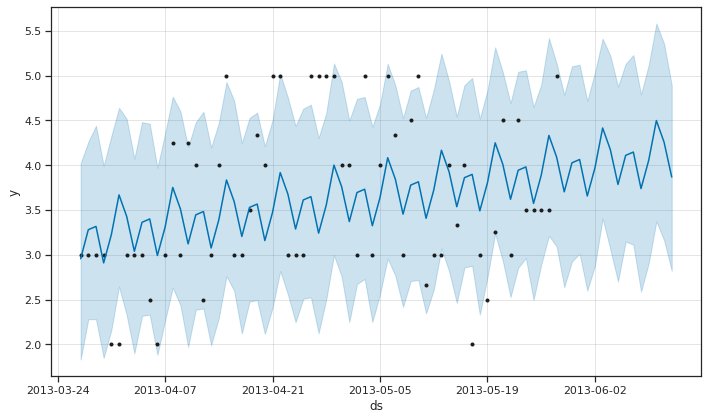

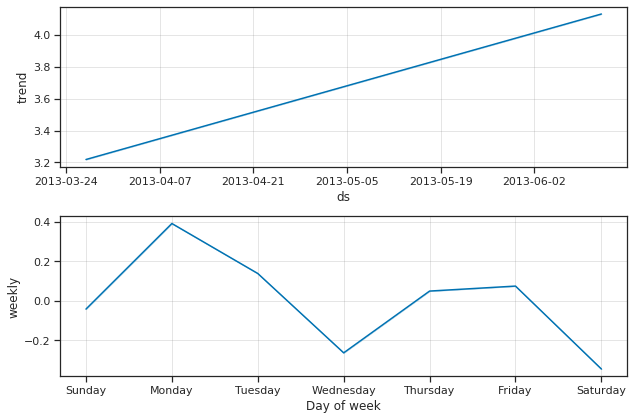

In [24]:
# use Prophet to do time series analysis on dataset stress_u16
m = Prophet().fit(stress_u16_)
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)

# plot stress prediction with dataset
print('==== time series plot of stress_u16 ====')
fig1 = m.plot(forecast)
print(fig1)

# plot the component of "trend" and "weekly"
fig2 = m.plot_components(forecast)
print(fig2)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Figure(720x432)
Figure(648x432)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Figure(720x432)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Figure(648x432)
Figure(720x432)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Figure(648x432)
Figure(720x432)
Figure(648x432)


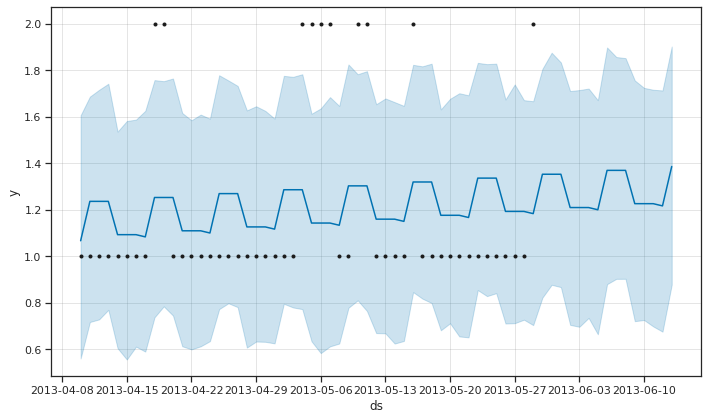

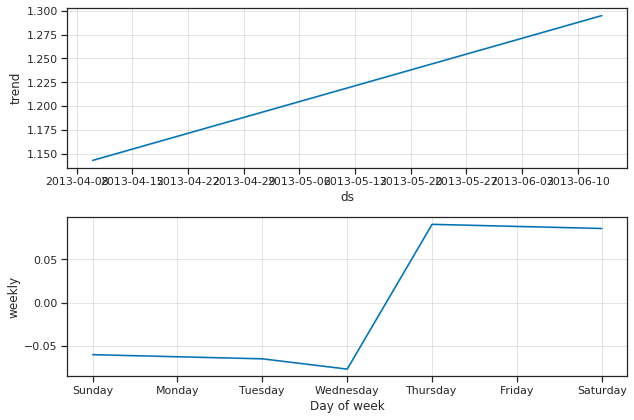

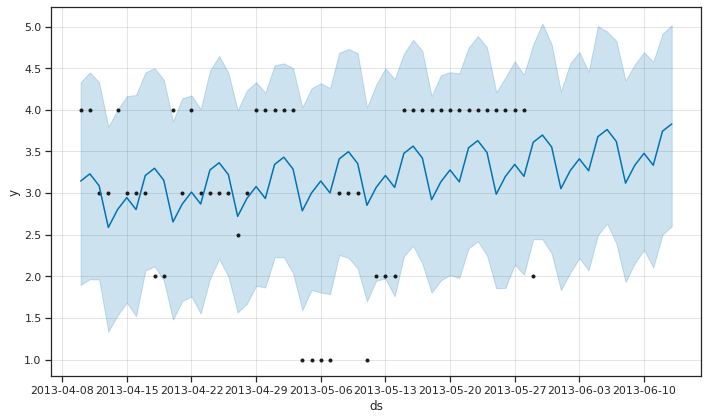

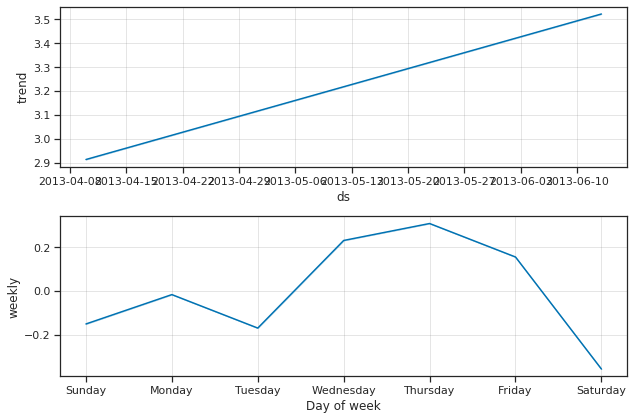

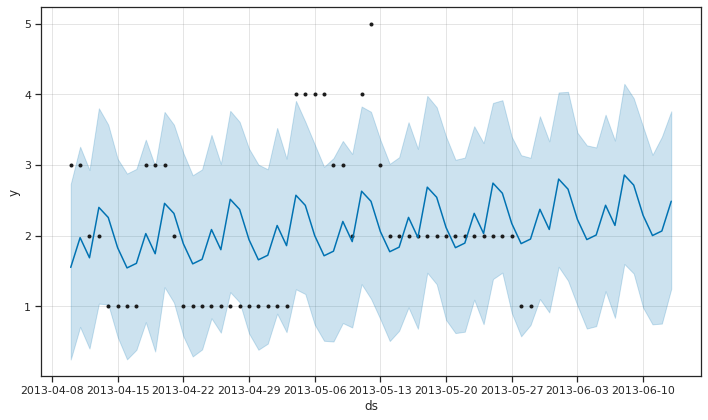

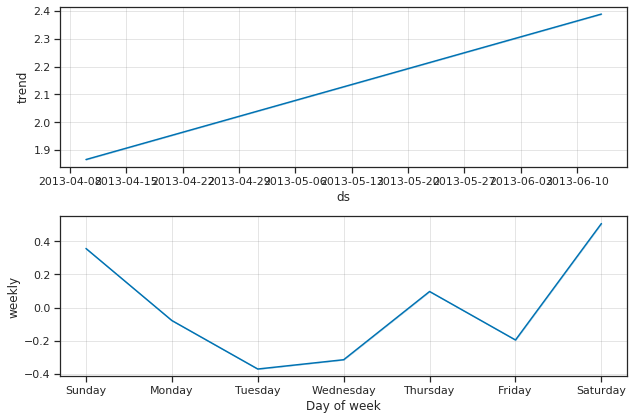

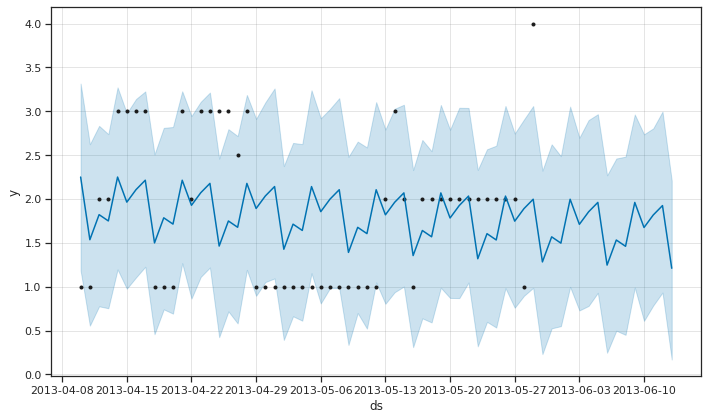

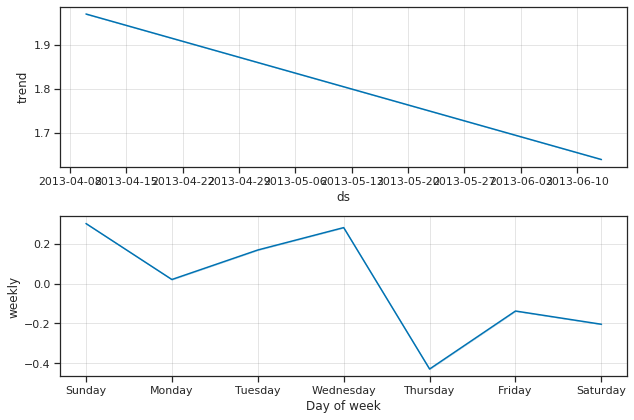

In [25]:
# use Prophet to do time series analysis on dataset act_u16
act_types = ['relaxing', 'working', 'other_relaxing', 'other_working']

for act in act_types:
    df = act_u16[['date', act]]
    df.rename(columns={'date': 'ds', act: 'y'}, 
              inplace=True)
    m = Prophet().fit(df)
    future = m.make_future_dataframe(periods=15)
    forecast = m.predict(future)

    # plot stress prediction with dataset
    fig1 = m.plot(forecast)
    print(fig1)

    # plot the component of "trend" and "weekly"
    fig2 = m.plot_components(forecast)
    print(fig2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


==== time series plot of sen_act_u16 ====
Figure(720x432)
Figure(648x432)


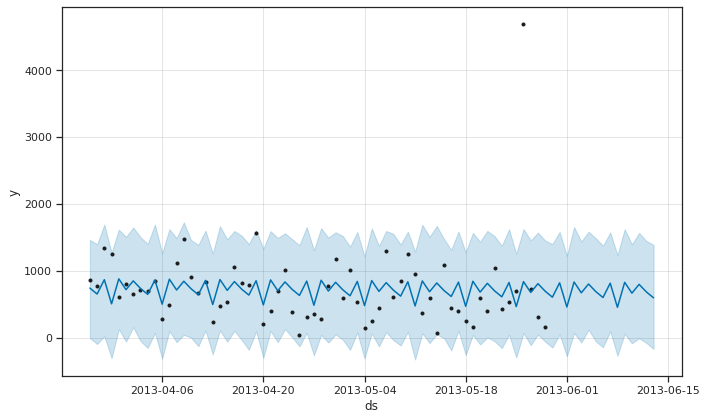

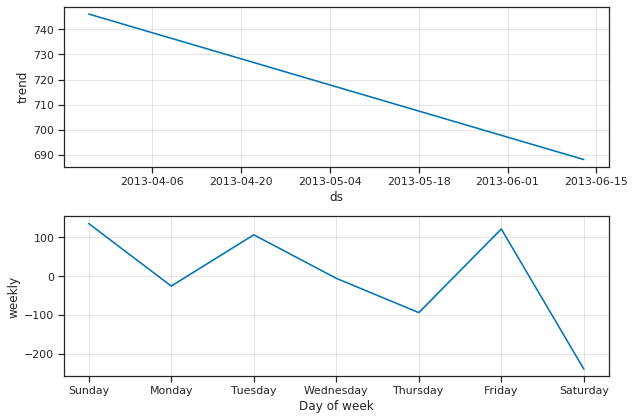

In [26]:
# use Prophet to do time series analysis on dataset sen_act_u16
sen_act_u16_ = sen_act_u16.rename(
    columns={'date': 'ds', 'activity_level': 'y'}, 
    inplace=False)
m = Prophet().fit(sen_act_u16_)
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)

# plot stress prediction with dataset
print('==== time series plot of sen_act_u16 ====')
fig1 = m.plot(forecast)
print(fig1)

# plot the component of "trend" and "weekly"
fig2 = m.plot_components(forecast)
print(fig2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


==== time series plot of stress_u10 ====
Figure(720x432)
Figure(648x432)


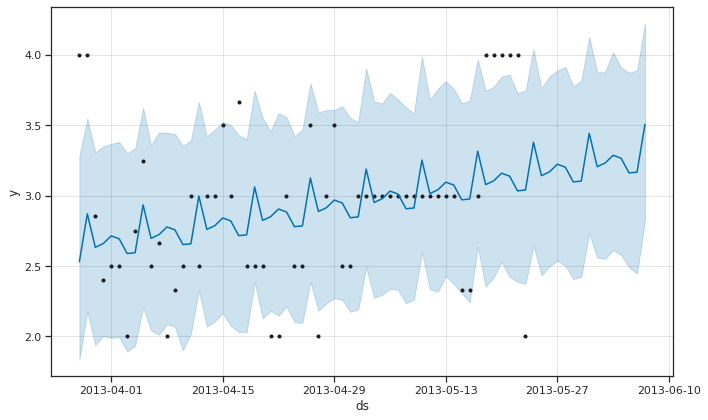

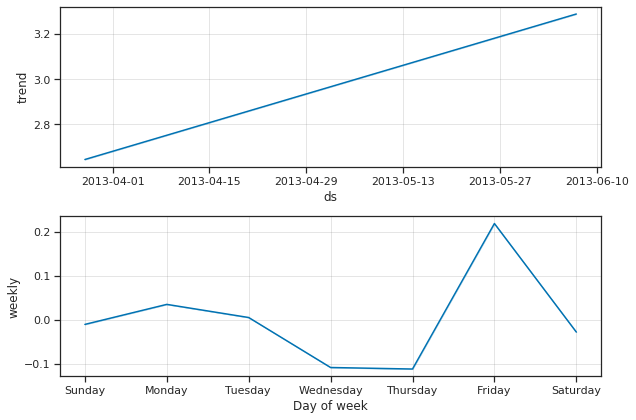

In [27]:
# impute data in stress_u10
stress_u10 = stress_u10.set_index('date').\
                resample('D').ffill().reset_index()
stress_u10_ = stress_u10.rename(
    columns={'date': 'ds', 'stress_value': 'y'}, 
    inplace=False)

# use Prophet to do time series analysis on dataset stress_u10
m = Prophet().fit(stress_u10_)
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)

# plot stress prediction with dataset
print('==== time series plot of stress_u10 ====')
fig1 = m.plot(forecast)
print(fig1)

# plot the component of "trend" and "weekly"
fig2 = m.plot_components(forecast)
print(fig2)

In [28]:
# process act_u10
# impute missing date and according activity from previous entry
act_u10 = act_u10.set_index('date').\
             resample('D').ffill().reset_index()

print(act_u10.head().to_string(index=False))
print(act_u10.shape)

      date  relaxing  working  other_relaxing  other_working
2013-04-08       2.0      3.0             1.0            1.0
2013-04-09       2.0      2.0             1.0            1.0
2013-04-10       1.0      3.0             1.0            1.0
2013-04-11       1.0      3.0             1.0            1.0
2013-04-12       1.0      3.0             1.0            1.0
(21, 5)


In [0]:
# impute data in sen_act_u10
sen_act_u10 = sen_act_u10.set_index('date').\
                resample('D').ffill().reset_index()
sen_act_u10_ = sen_act_u10.rename(
    columns={'date': 'ds', 'activity_level': 'y'}, 
    inplace=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.


Figure(720x432)
Figure(648x432)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.


Figure(720x432)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.


Figure(648x432)
Figure(720x432)
Figure(648x432)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.


Figure(720x432)
Figure(648x432)


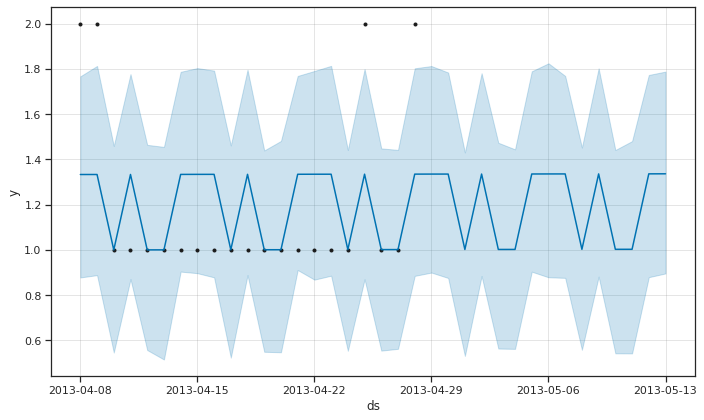

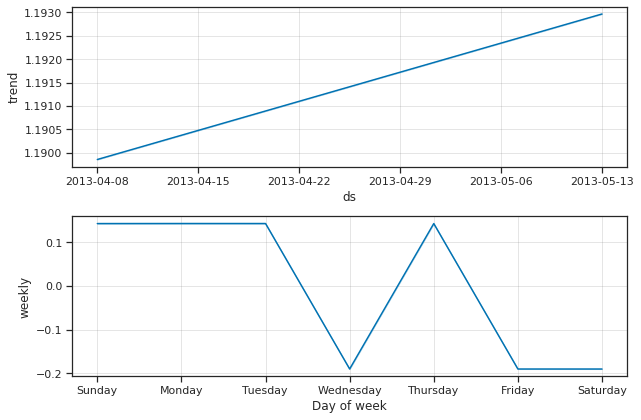

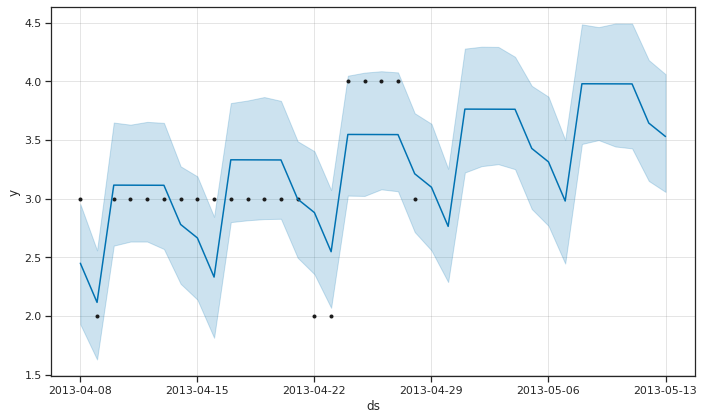

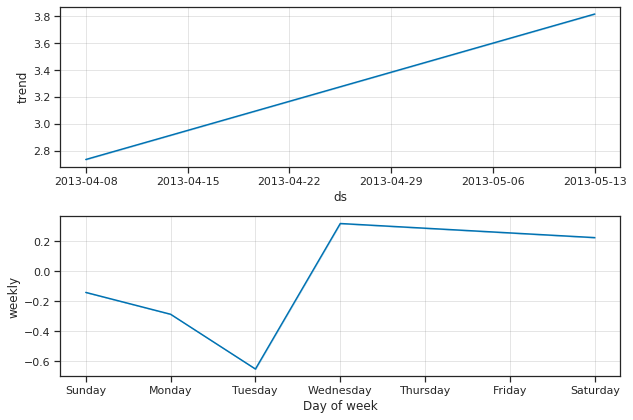

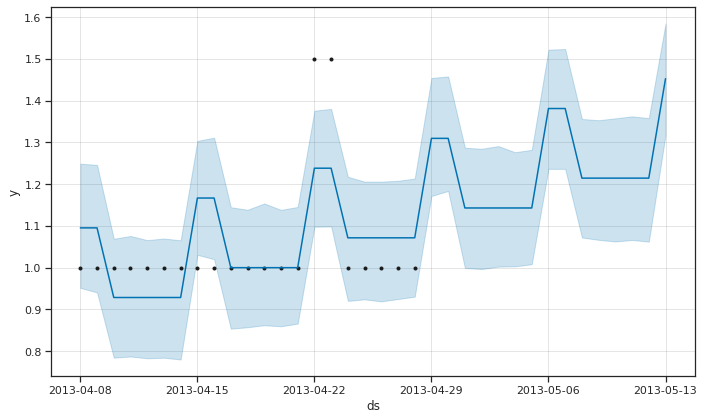

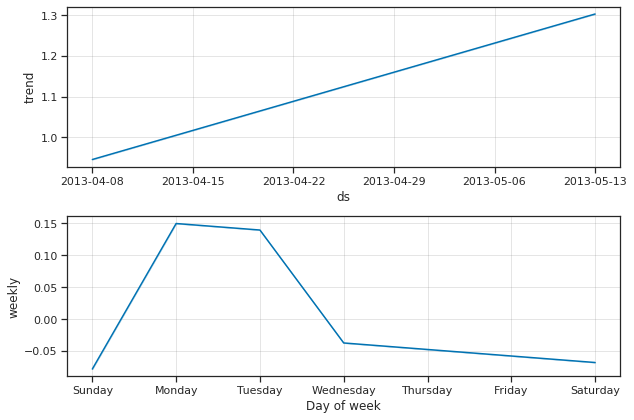

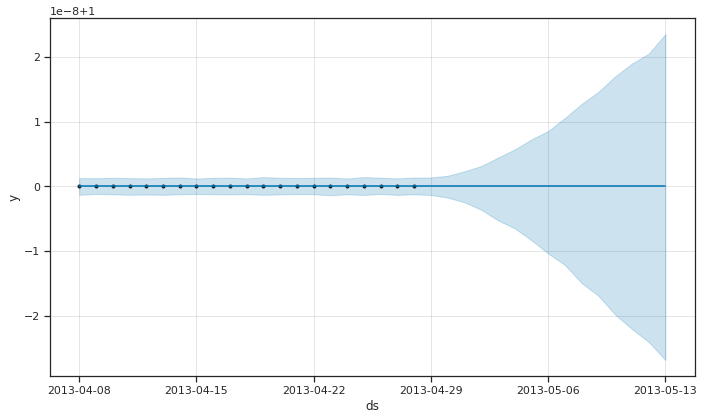

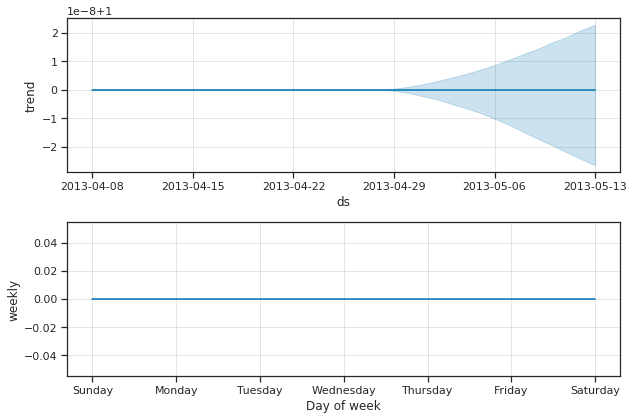

In [30]:
# use Prophet to do time series analysis on dataset act_u10
act_types = ['relaxing', 'working', 'other_relaxing', 'other_working']

for act in act_types:
    df = act_u10[['date', act]]
    df.rename(columns={'date': 'ds', act: 'y'}, 
              inplace=True)
    m = Prophet().fit(df)
    future = m.make_future_dataframe(periods=15)
    forecast = m.predict(future)

    # plot stress prediction with dataset
    fig1 = m.plot(forecast)
    print(fig1)

    # plot the component of "trend" and "weekly"
    fig2 = m.plot_components(forecast)
    print(fig2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


==== time series plot of sen_act_u10 ====
Figure(720x432)
Figure(648x432)


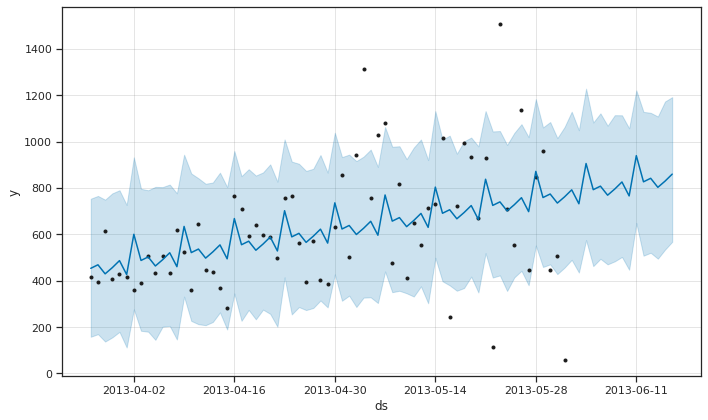

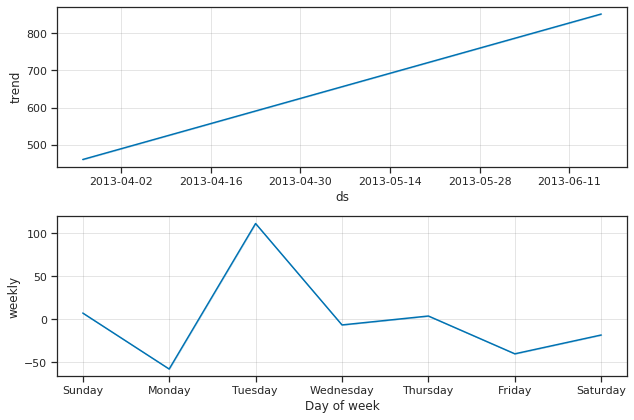

In [31]:
# use Prophet to do time series analysis on sen_act_u10
m = Prophet().fit(sen_act_u10_)
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)

# plot stress prediction with dataset
print('==== time series plot of sen_act_u10 ====')
fig1 = m.plot(forecast)
print(fig1)

# plot the component of "trend" and "weekly"
fig2 = m.plot_components(forecast)
print(fig2)

### Compute the Correlation of Stress and Activity
- Overall: daily
- Component: weekly

#### Correlation: EMA Activity ~ Stress

In [32]:
# overall level of correlation for u16
df_u16 = pd.merge(stress_u16, act_u16)

# calculate the corr without date for u16
print(df_u16.iloc[:, 1:].corr(method='pearson'))

                stress_value  relaxing   working  other_relaxing  other_working
stress_value        1.000000  0.101378  0.017115       -0.174192      -0.090875
relaxing            0.101378  1.000000 -0.670465        0.567296      -0.485395
working             0.017115 -0.670465  1.000000       -0.616009       0.115386
other_relaxing     -0.174192  0.567296 -0.616009        1.000000      -0.562496
other_working      -0.090875 -0.485395  0.115386       -0.562496       1.000000


In [33]:
# weekly level of correlation for u16
df_u16['week'] = df_u16['date'].dt.week
df_u16_weekly = df_u16[
    ['week', 'stress_value', 'relaxing', 'working', \
     'other_relaxing', 'other_working']]

# take weekly means
df_u16_weekly = \
    df_u16_weekly.groupby(by=['week'], as_index=False).mean()
print(df_u16_weekly.iloc[:, 1:].corr(method='pearson'))

                stress_value  relaxing   working  other_relaxing  other_working
stress_value        1.000000  0.082809 -0.164597       -0.291186      -0.100157
relaxing            0.082809  1.000000 -0.882664        0.777359      -0.605966
working            -0.164597 -0.882664  1.000000       -0.605000       0.265841
other_relaxing     -0.291186  0.777359 -0.605000        1.000000      -0.627087
other_working      -0.100157 -0.605966  0.265841       -0.627087       1.000000


In [34]:
# overall level of correlation for u10
df_u10 = pd.merge(stress_u10, act_u10)

# calculate the corr without date for u10
print(df_u10.iloc[:,1:].corr(method='pearson'))

                stress_value  relaxing   working  other_relaxing  other_working
stress_value        1.000000 -0.227897  0.079760       -0.125071            NaN
relaxing           -0.227897  1.000000 -0.040145       -0.157378            NaN
working             0.079760 -0.040145  1.000000       -0.590724            NaN
other_relaxing     -0.125071 -0.157378 -0.590724        1.000000            NaN
other_working            NaN       NaN       NaN             NaN            NaN


In [35]:
# weekly level of correlation for u10
df_u10['week'] = df_u10['date'].dt.week
df_u10_weekly = df_u10[
    ['week', 'stress_value', 'relaxing', 'working', \
     'other_relaxing', 'other_working']]

# take weekly means
df_u10_weekly = \
    df_u10_weekly.groupby(by=['week'], as_index=False).mean()
print(df_u10_weekly.iloc[:,1:].corr(method='pearson'))

                stress_value  relaxing   working  other_relaxing  other_working
stress_value        1.000000 -0.993399 -0.075094       -0.397360            NaN
relaxing           -0.993399  1.000000  0.188982        0.500000            NaN
working            -0.075094  0.188982  1.000000        0.944911            NaN
other_relaxing     -0.397360  0.500000  0.944911        1.000000            NaN
other_working            NaN       NaN       NaN             NaN            NaN


#### Correlation: Sensing Activity ~ Stress

In [36]:
# overall level of correlation for u16
df_u16 = pd.merge(stress_u16, sen_act_u16)

# calculate the corr without date for u16
print(df_u16.iloc[:, 1:].corr(method='pearson'))

                stress_value  activity_level
stress_value        1.000000       -0.046698
activity_level     -0.046698        1.000000


In [37]:
# weekly level of correlation for u16
df_u16['week'] = df_u16['date'].dt.week
df_u16_weekly = df_u16[
    ['week', 'stress_value', 'activity_level']]

# take weekly means
df_u16_weekly = \
    df_u16_weekly.groupby(by=['week'], as_index=False).mean()
print(df_u16_weekly.iloc[:, 1:].corr(method='pearson'))

                stress_value  activity_level
stress_value        1.000000       -0.168733
activity_level     -0.168733        1.000000


In [38]:
# overall level of correlation for u10
df_u10 = pd.merge(stress_u10, sen_act_u10)

# calculate the corr without date for u10
print(df_u10.iloc[:, 1:].corr(method='pearson'))

                stress_value  activity_level
stress_value        1.000000        0.013439
activity_level      0.013439        1.000000


In [39]:
# weekly level of correlation for u10
df_u10['week'] = df_u10['date'].dt.week
df_u10_weekly = df_u10[
    ['week', 'stress_value', 'activity_level']]

# take weekly means
df_u10_weekly = \
    df_u10_weekly.groupby(by=['week'], as_index=False).mean()
print(df_u10_weekly.iloc[:, 1:].corr(method='pearson'))

                stress_value  activity_level
stress_value        1.000000        0.536167
activity_level      0.536167        1.000000


# Task 2: Correlation of More Attributes

### Load Sleep Data

In [40]:
sleep_df = [] # a list storing the df of each qualified .json file
json_sleep_list = get_json_list('Sleep')

for file_name in json_sleep_list:
    # read json
    df = pd.read_json(
        os.path.join(stu_path, 'EMA/response/Sleep', file_name))

    # time format transformation
    df.columns = df.columns.str.replace(' ', '_')
    df['resp_time'] = pd.to_datetime(df['resp_time'], unit='s')
    df['date'] = df['resp_time'].dt.date
    df['time'] = df['resp_time'].dt.time
        
    # take only the columns we need
    columns_required = ['date', 'hour']
    df = df[columns_required]

    # add student_id from filename
    student_id = file_name[6: 9]
    df.insert(0, 'student_id', student_id)

    # in each accepted file, drop the rows with NaN
    df.dropna(subset = columns_required, inplace=True)

    sleep_df.append(df)

# concatenate all the .json files into one big table
sleep_table = pd.concat(sleep_df)
sleep_table.sort_values(
    by=['student_id', 'date'],
    inplace=True)

# get daily average
sleep_table = sleep_table.groupby(
    by=['student_id', 'date'], 
    as_index=False).mean()
print(sleep_table.head().to_string(index=False))

student_id        date  hour
       u00  2013-03-25   8.0
       u00  2013-03-26   7.5
       u00  2013-03-27   8.0
       u00  2013-03-28   6.5
       u00  2013-03-29   6.0


Get mean

In [41]:
sleep_table.drop(['date'], axis=1)
sleep_table = sleep_table.groupby('student_id').mean()
sleep_table = sleep_table.reset_index()
print(sleep_table.head())

  student_id      hour
0        u00  7.352713
1        u01  7.312500
2        u02  7.891304
3        u03  8.142857
4        u04  6.576923


### Load Conversation Data

In [42]:
conv_df = []
csv_conv_list = get_csv_list('conversation')

for file_name in csv_conv_list:
    df = pd.read_csv(
        os.path.join(stu_path, 'sensing/conversation', file_name))

    # reformat column name
    df.columns = df.columns.str.replace(' ', '_')
    df.rename(columns={'_end_timestamp': 'end_timestamp'}, 
              inplace=True)

    # add student_id column from file name
    student_id = file_name[13: 16]
    df.insert(0, 'student_id', student_id)

    # convert timestamp
    df['start_timestamp'] = pd.to_datetime(
        df['start_timestamp'], unit='s')
    df['end_timestamp'] = pd.to_datetime(
        df['end_timestamp'], unit='s')
    
    # add a conv_duration column to store the difference
    # between the two timestamps in a row
    df['conv_duration'] = (df['end_timestamp'] - df['start_timestamp'])\
        .dt.seconds.values

    # add date column for further grouping
    df['date'] = df['start_timestamp'].dt.date
     
    conv_df.append(df)

conv_table = pd.concat(conv_df)
print(conv_table.head().to_string(index=False))

student_id     start_timestamp       end_timestamp  conv_duration        date
       u00 2013-03-27 04:46:40 2013-03-27 04:50:12            212  2013-03-27
       u00 2013-03-27 11:10:21 2013-03-27 11:17:45            444  2013-03-27
       u00 2013-03-27 11:25:16 2013-03-27 11:49:53           1477  2013-03-27
       u00 2013-03-27 11:50:33 2013-03-27 11:51:34             61  2013-03-27
       u00 2013-03-27 12:03:06 2013-03-27 12:04:26             80  2013-03-27


In [0]:
# compute the conv_duration_day/evening
conv_table['conv_duration_day'] = np.where(
    ((conv_table['start_timestamp'].dt.hour >= 9) \
     & (conv_table['start_timestamp'].dt.hour < 18)), 
    conv_table['conv_duration'], 
    0)
conv_table['conv_duration_evening'] = \
    conv_table['conv_duration'] - conv_table['conv_duration_day']

# count frequency
conv_table['conv_freq'] = 1
conv_table['conv_freq_day'] = np.where(
    ((conv_table['start_timestamp'].dt.hour >= 9) \
     & (conv_table['start_timestamp'].dt.hour < 18)), 
    1, 
    0)
conv_table['conv_freq_evening'] = 1 - conv_table['conv_freq_day']

In [44]:
# take the columns we nead
conv_table = conv_table[
    ['student_id', 'date', 'conv_duration', 'conv_duration_day', \
     'conv_duration_evening', 'conv_freq', 'conv_freq_day', \
     'conv_freq_evening']]
print(conv_table.head().to_string(index=False))

student_id        date  conv_duration  conv_duration_day  conv_duration_evening  conv_freq  conv_freq_day  conv_freq_evening
       u00  2013-03-27            212                  0                    212          1              0                  1
       u00  2013-03-27            444                444                      0          1              1                  0
       u00  2013-03-27           1477               1477                      0          1              1                  0
       u00  2013-03-27             61                 61                      0          1              1                  0
       u00  2013-03-27             80                 80                      0          1              1                  0


In [45]:
# group by student_id and date
agg_function = {
    'conv_duration': 'mean', 
    'conv_duration_day': 'mean', 
    'conv_duration_evening': 'mean', 
    'conv_freq': 'sum',
    'conv_freq_day': 'sum',
    'conv_freq_evening': 'sum'}
conv_table = conv_table.groupby(
    by=['student_id', 'date'],
    as_index=False).agg(agg_function)
print(conv_table.head().to_string(index=False))

student_id        date  conv_duration  conv_duration_day  conv_duration_evening  conv_freq  conv_freq_day  conv_freq_evening
       u00  2013-03-27    1093.857143         645.142857             448.714286         21             10                 11
       u00  2013-03-28     995.333333         386.857143             608.476190         21              7                 14
       u00  2013-03-29     898.343750         452.687500             445.656250         32             10                 22
       u00  2013-03-30     990.062500          76.812500             913.250000         32              4                 28
       u00  2013-03-31    1630.045455         368.863636            1261.181818         22              7                 15


Get mean

In [46]:
conv_table.drop(['date'], axis=1)
conv_table = conv_table.groupby('student_id').mean()
print(conv_table.head().to_string(index=False))

 conv_duration  conv_duration_day  conv_duration_evening  conv_freq  conv_freq_day  conv_freq_evening
    784.261193         345.741551             438.519642  31.984848      12.469697          19.515152
    816.785620         169.864006             646.921614  39.618182      10.109091          29.509091
   1005.261528         223.701270             781.560259  22.815385       6.292308          16.523077
    557.059714         349.031881             208.027833  11.116279       4.720930           6.395349
    562.329067         239.704811             322.624256  47.189655      19.500000          27.689655


### Load PerceivedStressScale Data

In [47]:
pstress = pd.read_csv(
    os.path.join(stu_path, 'survey/PerceivedStressScale.csv'))
print(pstress.head().to_string(index=False))

 uid type 1. In the last month, how often have you been upset because of something that happened unexpectedly? 2. In the last month, how often have you felt that you were unable to control the important things in your life? 3. In the last month, how often have you felt nervous and "stressed"? 4. In the last month, how often have you felt confident about your ability to handle your personal problems? 5. In the last month, how often have you felt that things were going your way? 6. In the last month, how often have you found that you could not cope with all the things that you had to do? 7. In the last month, how often have you been able to control irritations in your life? 8. In the last month, how often have you felt that you were on top of things? 9. In the last month, how often have you been angered because of things that were outside of your control? 10. In the last month, how often have you felt difficulties were piling up so high that you could not overcome them?
 u00  pre        

In [48]:
# select columns
cols = pstress.columns
pstress = pstress[[cols[0], cols[1], cols[4]]]

# rename columns
pstress.columns = ["student_id" ,"type", "stressed"]

# re-encode values
pstress = pstress.replace(
    to_replace =['Very often', 'Fairly often', 'Sometime', \
                 'Almost never', 'Never'], 
    value = [4,3,2,1,0]) 
pstress.stressed = pd.to_numeric(pstress.stressed)
print(pstress.head().to_string(index=False))

student_id type  stressed
       u00  pre       3.0
       u01  pre       2.0
       u02  pre       2.0
       u03  pre       2.0
       u04  pre       3.0


### Correlation Analysis

In [49]:
# join all the attributed together
merged = pd.merge(conv_table, pstress, on='student_id')
sleep_merged = sleep_table[['student_id', 'hour']]
merged = pd.merge(merged, sleep_merged, on='student_id')

print(merged.head().to_string(index=False))

student_id  conv_duration  conv_duration_day  conv_duration_evening  conv_freq  conv_freq_day  conv_freq_evening  type  stressed      hour
       u00     784.261193         345.741551             438.519642  31.984848      12.469697          19.515152   pre       3.0  7.352713
       u00     784.261193         345.741551             438.519642  31.984848      12.469697          19.515152  post       2.0  7.352713
       u01     816.785620         169.864006             646.921614  39.618182      10.109091          29.509091   pre       2.0  7.312500
       u01     816.785620         169.864006             646.921614  39.618182      10.109091          29.509091  post       2.0  7.312500
       u02    1005.261528         223.701270             781.560259  22.815385       6.292308          16.523077   pre       2.0  7.891304


In [0]:
# pre and post design
merged_post = merged.loc[merged["type"] == "post"]
merged_pre = merged.loc[merged["type"] == "pre"]

#### Correlation with post stress

In [51]:
post_corr = pg.pairwise_corr(
    data=merged_post,
    columns=[
        ['stressed'], 
        ['conv_duration', 'conv_duration_day', \
         'conv_duration_evening', 'conv_freq', \
         'conv_freq_day', 'conv_freq_evening', 'hour']
    ], 
    method='pearson')

print('post correlation\n',
    post_corr.sort_values(by=['p-unc'])[['X', 'Y', 'r', 'p-unc']].head())

post correlation
           X                  Y      r     p-unc
6  stressed               hour -0.218  0.183112
3  stressed          conv_freq -0.190  0.247855
5  stressed  conv_freq_evening -0.170  0.301208
4  stressed      conv_freq_day -0.153  0.352136
1  stressed  conv_duration_day  0.092  0.575731


In [52]:
pre_corr = pg.pairwise_corr(
    data=merged_pre,
    columns=[
        ['stressed'], 
        ['conv_duration', 'conv_duration_day', \
         'conv_duration_evening', 'conv_freq', \
         'conv_freq_day', 'conv_freq_evening', 'hour']], 
    method='pearson')

print('pre correlation\n',
    post_corr.sort_values(by=['p-unc'])[['X', 'Y', 'r', 'p-unc']].head(8))

pre correlation
           X                      Y      r     p-unc
6  stressed                   hour -0.218  0.183112
3  stressed              conv_freq -0.190  0.247855
5  stressed      conv_freq_evening -0.170  0.301208
4  stressed          conv_freq_day -0.153  0.352136
1  stressed      conv_duration_day  0.092  0.575731
0  stressed          conv_duration  0.074  0.656138
2  stressed  conv_duration_evening  0.038  0.819917


### Classification

In [53]:
stress_df = []
json_stress_list = get_json_list('Stress')

# for file_name in json_files:
for file_name in json_stress_list:
    # read json
    df = pd.read_json(
        os.path.join(stu_path, 'EMA/response/Stress', file_name),
        dtype={'level': int})

    # only accept .json files containing the two columns we require   
    if 'resp_time' in df.columns.to_list() \
        and 'level' in df.columns.to_list(): 
        # accept this file
        print(file_name, df.columns.to_list(), '=' * 5 + '>', 'accepted')

        # reformat column names
        df.columns = df.columns.str.replace(' ', '_')
        
        # reformat timestamp
        df['resp_time'] = pd.to_datetime(df['resp_time'], unit='s')
        df['date'] = df['resp_time'].dt.date
        df['time'] = df['resp_time'].dt.time

        # add student_id from filename
        student_id = file_name[7: 10]
        df.insert(0, 'student_id', student_id)

        # drop the rows with NaN in 'level' or 'resp_time'
        df.dropna(subset = ['resp_time', 'level'], inplace=True)
        
        # take only the columns we need
        df = df[['student_id', 'date', 'time', 'level']]
        stress_df.append(df)
    
    else: # reject this file
        print(file_name, df.columns.to_list(), '=' * 5 + '>', 'rejected')

# concatenate all the .json files into one big table
stress_table = pd.concat(stress_df)
print(stress_table.head().to_string(index=False))

Stress_u00.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u01.json ['level', 'location', 'resp_time', 'null'] =====> accepted
Stress_u02.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u03.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u04.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u05.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u07.json ['level', 'location', 'resp_time', 'null'] =====> accepted
Stress_u08.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u09.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u10.json ['level', 'location', 'resp_time', 'null'] =====> accepted
Stress_u12.json ['level', 'location', 'resp_time', 'null'] =====> accepted
Stress_u13.json ['null', 'resp_time'] =====> rejected
Stress_u14.json ['null', 'resp_time', 'level', 'location'] =====> accepted
Stress_u15.json ['null', 'resp_time', 'level',

In [54]:
stress_table = stress_table[['student_id', 'level']]
stress_table.level = stress_table['level'].astype('int')
print(stress_table.head())

# group by median
stress_table = stress_table.groupby('student_id').apply(np.median)
stress_table = stress_table.reset_index()
stress_table.columns = ['student_id', 'level']
stress_table.level = stress_table['level'].astype('int')
print(stress_table.head())

  student_id  level
5        u00      2
6        u00      2
7        u00      2
8        u00      1
9        u00      4
  student_id  level
0        u00      2
1        u01      2
2        u02      1
3        u03      3
4        u04      2


In [55]:
# Get mean of activity_table
activity_table = activity_table.groupby('student_id').mean()
activity_table = activity_table.reset_index()
print(activity_table.head())

  student_id  relaxing   working  other_relaxing  other_working
0        u00  1.578947  2.052632        1.473684       2.684211
1        u01  2.333333  1.666667        3.333333       2.000000
2        u02  1.000000  2.250000        2.000000       2.375000
3        u03  1.909091  2.545455        1.727273       1.090909
4        u04  2.846154  1.923077        2.461538       1.846154


In [56]:
conv_df = []
csv_conv_list = get_csv_list('conversation')

for file_name in csv_conv_list:
    df = pd.read_csv(
        os.path.join(stu_path, 'sensing/conversation', file_name))

    # reformat column name
    df.columns = df.columns.str.replace(' ', '_')
    df.rename(columns={'_end_timestamp': 'end_timestamp'}, 
              inplace=True)

    # add student_id column from file name
    student_id = file_name[13: 16]
    df.insert(0, 'student_id', student_id)

    # convert timestamp
    df['start_timestamp'] = pd.to_datetime(
        df['start_timestamp'], unit='s')
    df['end_timestamp'] = pd.to_datetime(
        df['end_timestamp'], unit='s')
    
    # add a conv_duration column to store the difference
    # between the two timestamps in a row
    df['conv_duration'] = (df['end_timestamp'] - df['start_timestamp'])\
        .dt.seconds.values

    # add date column for further grouping
    df['date'] = df['start_timestamp'].dt.date
     
    conv_df.append(df)

conv_table = pd.concat(conv_df)
print(conv_table.head().to_string(index=False))

student_id     start_timestamp       end_timestamp  conv_duration        date
       u00 2013-03-27 04:46:40 2013-03-27 04:50:12            212  2013-03-27
       u00 2013-03-27 11:10:21 2013-03-27 11:17:45            444  2013-03-27
       u00 2013-03-27 11:25:16 2013-03-27 11:49:53           1477  2013-03-27
       u00 2013-03-27 11:50:33 2013-03-27 11:51:34             61  2013-03-27
       u00 2013-03-27 12:03:06 2013-03-27 12:04:26             80  2013-03-27


In [57]:
conv_table = conv_table.groupby('student_id').mean()
print(conv_table.head())

            conv_duration
student_id               
u00            760.111795
u01            764.026159
u02            849.729602
u03            519.866109
u04            550.232371


In [65]:
# join all the tables
df = pd.merge(activity_table, conv_table, on =["student_id"])
df = pd.merge(df, sleep_table, on = ["student_id"])
df = pd.merge(df, stress_table, on = ["student_id"])
print(df.head())

df = df.round(3) 
print(df.info())

  student_id  relaxing   working  ...  conv_duration      hour  level
0        u00  1.578947  2.052632  ...     760.111795  7.352713      2
1        u01  2.333333  1.666667  ...     764.026159  7.312500      2
2        u02  1.000000  2.250000  ...     849.729602  7.891304      1
3        u03  1.909091  2.545455  ...     519.866109  8.142857      3
4        u04  2.846154  1.923077  ...     550.232371  6.576923      2

[5 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 0 to 45
Data columns (total 8 columns):
student_id        46 non-null object
relaxing          46 non-null float64
working           46 non-null float64
other_relaxing    46 non-null float64
other_working     46 non-null float64
conv_duration     46 non-null float64
hour              46 non-null float64
level             46 non-null int64
dtypes: float64(6), int64(1), object(1)
memory usage: 3.2+ KB
None


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc460fb7748>]],
      dtype=object)

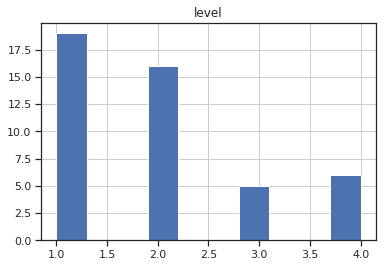

In [66]:
# plot the histogram of the distribution of our target stress level
df.hist(column='level')

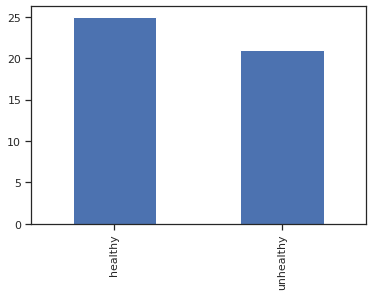

In [67]:
import matplotlib.pyplot as plt
# merge the target class into 2 classes
# regard 1 and 4 as healthy(0), 2 and 3 unhealthy(1)

df['target'] = df['level'].apply(
    lambda x: 'healthy' if x in [1, 4] else 'unhealthy')
df['target'].value_counts().plot.bar()

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = df[['hour', 'working', 'other_working', 'relaxing', \
      'other_relaxing', 'conv_duration', 'hour']]  
y = df['target']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

#Create a Gaussian Classifier
clf_1 = RandomForestClassifier().fit(X_train,y_train)
y_pred = clf_1.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of RandomForest:",metrics.accuracy_score(y_test, y_pred))

Accuracy of RandomForest: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



In [69]:
from sklearn import svm

#Create a svm Classifier
clf_2 = svm.SVC(kernel='linear') # Linear Kernel
clf_2.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf_2.predict(X_test)
print('Accuracy:',metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8
